In [8]:
# imports
import torch
from torch import nn
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import platform
from torch.autograd import Variable
import time
from efficientnet_pytorch import EfficientNet
import glob
import os

# vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics
from math import ceil
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL

# Model Instance

In [10]:
class Config:
    train_pcent = 0.8
    TRAIN_BS = 4
    VALID_BS = 4
    NB_EPOCHS = 4
    model_name = 'EfficientNETB2'
    reshape_size = (400, 400)
    num_classes = 4

In [11]:
class EfficientNETB2(nn.Module):
    def __init__(self, NUM_CLASSES=Config.num_classes, pretrained=True):
        super(EfficientNETB2, self).__init__()
        # model
        self.NUM_CLASSES = NUM_CLASSES
        self.effnet = self.load_effnet(pretrained)
        self.effnet._fc = nn.Linear(1408, self.NUM_CLASSES)
        self.out = nn.Sigmoid()
        
    def load_effnet(self, pretrained):
        if pretrained == True:
            effnet = EfficientNet.from_pretrained("efficientnet-b2")
        else:
            effnet = EfficientNet.from_name("efficientnet-b2")
        return effnet
        
    def forward(self, X):
        X = self.effnet(X)
        output = self.out(X)
        return(output)

In [14]:
model = torch.load('/Users/alfie/Git/SIIM-FISABIO-RSNA-COVID-19-Detection/models/EfficientNETB2-4/model.pth', map_location=torch.device('cpu'))

# Test Photo

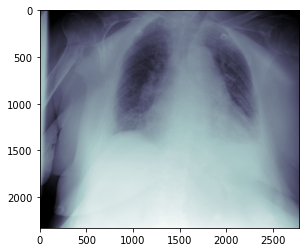

In [18]:
file_path = '../input/train_study_samples/00086460a852/9e8302230c91/65761e66de9f.dcm'
DCM = pydicom.dcmread(file_path)
arr = DCM.pixel_array
plt.imshow(arr, cmap=plt.cm.bone)
plt.show()

In [20]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data

In [32]:
# get image
image = dicom2array(file_path)
# recolour
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# resize
image = cv2.resize(image, Config.reshape_size)
# to tensor
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image) 

In [33]:
pred = model(image.unsqueeze(0)).squeeze()

In [34]:
pred

tensor([0.1596, 0.3530, 0.3403, 0.2949], grad_fn=<SqueezeBackward0>)